## Buscar dados no GitHub

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

## Carregando dados em um DataFrame Pandas

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

## Dando um saque nos dados

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

### Vendo os dados

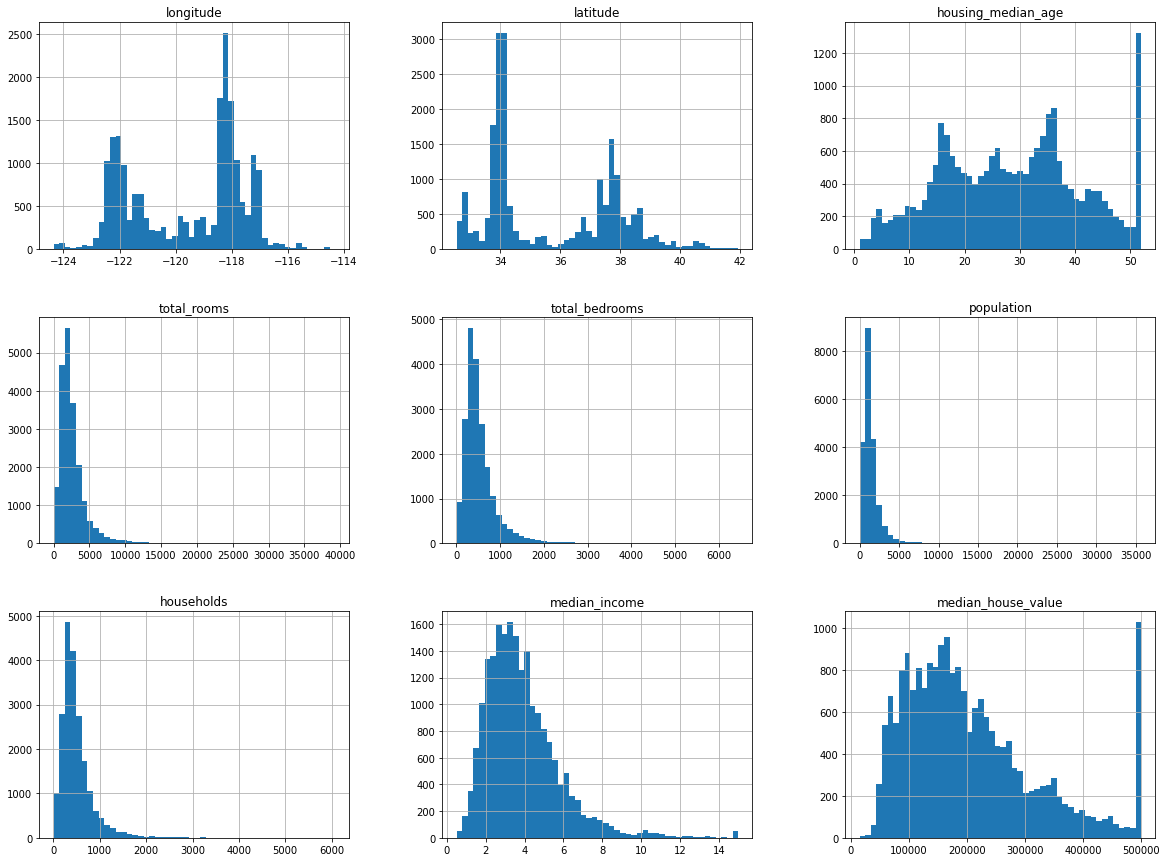

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Criando dados de teste

In [7]:
import numpy as np

np.random.seed(42)

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


### Separar por hash

In [8]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

16362 train + 4278 test


### Para adicionar um id

In [9]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
8       8    -122.26     37.84                42.0       2555.0   
10     10    -122.26     37.85                52.0       2202.0   
11     11    -122.26     37.85                52.0       3503.0   
12     12    -122.26     37.85                52.0       2491.0   
13     13    -122.26     37.84                52.0        696.0   

    total_bedrooms  population  households  median_income  median_house_value  \
8            665.0      1206.0       595.0         2.0804            226700.0   
10           434.0       910.0       402.0         3.2031            281500.0   
11           752.0      1504.0       734.0         3.2705            241800.0   
12           474.0      1098.0       468.0         3.0750            213500.0   
13           191.0       345.0       174.0         2.6736            191300.0   

   ocean_proximity         id  
8         NEAR BAY -122222.16  
10        NEAR BAY -122222.15  
11        NEAR BAY -122222.15  
12        NEAR BAY -122222.15  
13        NEAR BAY -122222.16

### Usando o Scikit-Learn

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

### Criando categoria de renda

<AxesSubplot:>

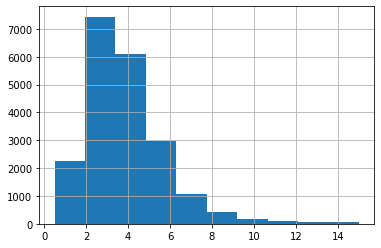

In [11]:
housing["median_income"].hist()

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

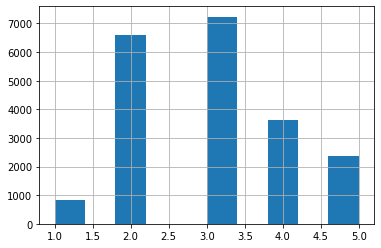

In [13]:
housing["income_cat"].hist()

### Amostragem estratificada

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

### Comparando amostragem estratificada com puramente aleatória

In [15]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039971  0.040213      0.973236       0.364964
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114341  0.109496     -4.318374      -0.084674

In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Descubra e Visualize os Dados para Obter Informações

In [17]:
housing = strat_train_set.copy()

### Visualizando Dados Geográficos

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

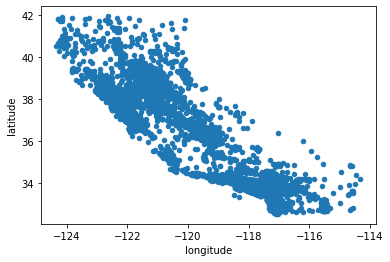

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

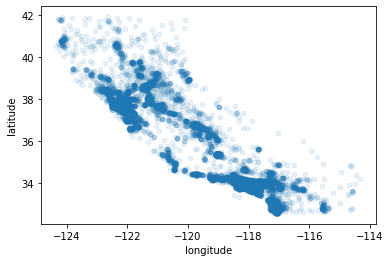

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

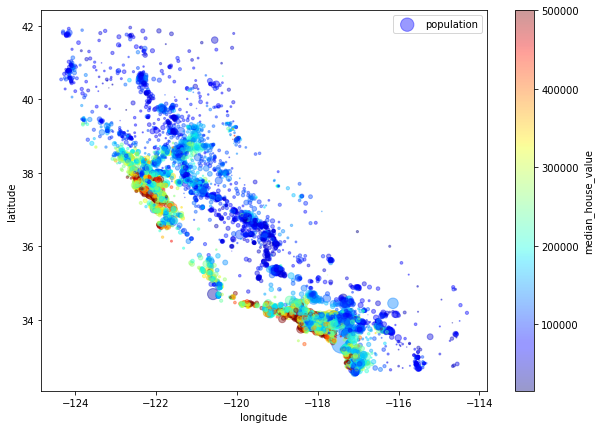

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

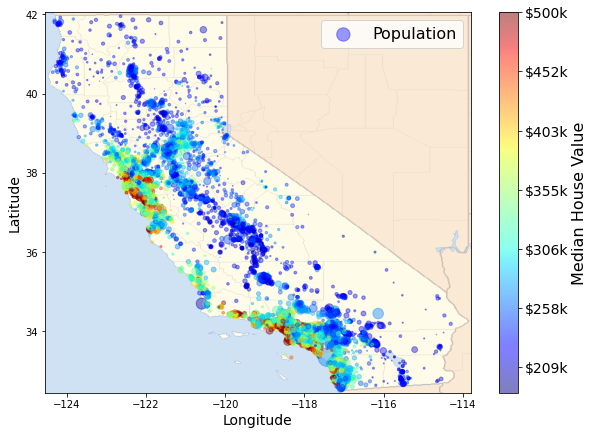

In [21]:
# Download the California image
images_path = os.path.join(".", "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

### Buscando Correlações

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

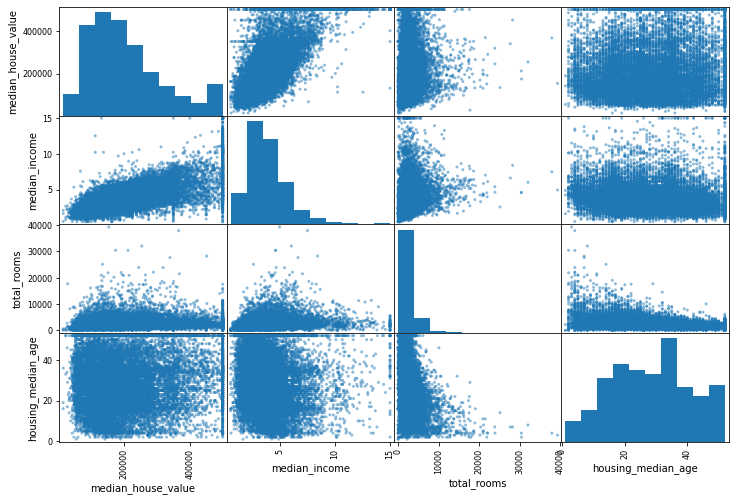

In [23]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

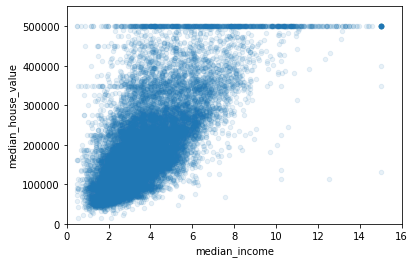

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

### Combinar atribuitos

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

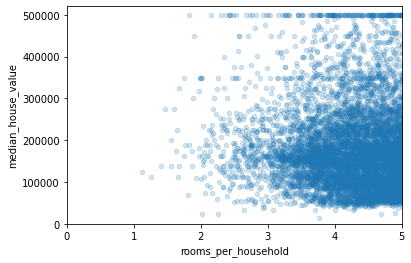

In [26]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [27]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575635     35.639314           28.653404   2622.539789   
std        2.001828      2.137963           12.574819   2138.417080   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.000000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.914639   1419.687379    497.011810       3.875884   
std        412.665649   1115.663036    375.696156       1.904931   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566950   
50%        433.000000   1164.000000    408.000000       3.541550   
75%        644.000000   1719.000000    602.000000       4.745325   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        207005.322372             5.440406           0.212873   
std         115701.297250             2.611696           0.057378   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442168           0.175304   
50%         179500.000000             5.232342           0.203027   
75%         263900.000000             6.056361           0.239816   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096469  
std                   11.584825  
min                    0.692308  
25%                    2.431352  
50%                    2.817661  
75%                    3.281420  
max                 1243.333333